# Rossmann Store Sales

Forecast sales using store, promotion, and competitor data

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

-**Id** - an Id that represents a (Store, Date) duple within the test set

-**Store** - a unique Id for each store

-**Sales** - the turnover for any given day (this is what you are predicting)

-**Customers** - the number of customers on a given day

-**Open** - an indicator for whether the store was open: 0 = closed, 1 = open

-**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

-**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools


-**StoreType** - differentiates between 4 different store models: a, b, c, d

-**Assortment** - describes an assortment level: a = basic, b = extra, c = extended

-**CompetitionDistance** - distance in meters to the nearest competitor store

-**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened

-**Promo** - indicates whether a store is running a promo on that day

-**Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

-**Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2

-**PromoInterval -** describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import itertools
import xgboost as xgb


In [3]:
# Display multiple commands output from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
def str_to_date(date):
    return datetime.strptime(date, '%Y-%m-%d').date()

In [1]:
from google.colab import files
uploaded = files.upload()


Saving sample_submission.csv to sample_submission.csv
Saving store.csv to store.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


## Data preparation

In [5]:
df_train = pd.read_csv('train.csv',
                       sep=',',
                       parse_dates=['Date'],
                       date_parser=str_to_date,
                       low_memory=False
)

In [6]:
df_store = pd.read_csv('store.csv',
                       low_memory=False
)

In [7]:
df_store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [8]:
df_store.shape

(1115, 10)

In [9]:
print()
df_store.nunique()        # Total no of unique values in each column

Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           654
CompetitionOpenSinceMonth      12
CompetitionOpenSinceYear       23
Promo2                          2
Promo2SinceWeek                24
Promo2SinceYear                 7
PromoInterval                   3
dtype: int64

In [10]:
df_store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [11]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [12]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [13]:
df_train.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

In [14]:

df_train.shape

(1017209, 9)

In [15]:
df_train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [17]:
# Drop closed stores and stores with zero sales
df_train = df_train.drop(df_train[(df_train.Open == 0) & (df_train.Sales == 0)].index)
df_train = df_train.drop(df_train[(df_train.Open == 1) & (df_train.Sales == 0)].index)
df_train = df_train.reset_index(drop=True)

The feature Date was decomposed into Year, Month, Day and deleted from dataset;

In [18]:
df_train['Day'] = df_train['Date'].dt.day
df_train['Month'] = df_train['Date'].dt.month
df_train['Year'] = df_train['Date'].dt.year

del df_train['Date']

In [19]:
df_store.isnull().values.any()

True

In [20]:
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Next filling missing in store.csv. CompetitionDistance was filling the median value. Other features were filling with 0;

In [21]:
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace=True)
df_store['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
df_store['CompetitionOpenSinceYear'].fillna(0, inplace=True)
df_store['Promo2SinceWeek'].fillna(0, inplace=True)
df_store['Promo2SinceYear'].fillna(0, inplace=True)
df_store['PromoInterval'].fillna(0, inplace=True)

Was merged information about store and training data into one dataframe;

In [22]:
df = pd.merge(df_train, df_store, how='left', on='Store')

df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,31,7,2015,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,31,7,2015,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,31,7,2015,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,31,7,2015,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,31,7,2015,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [23]:
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Store,844338.0,558.42,321.73,1.0,280.0,558.0,837.0,1115.0
DayOfWeek,844338.0,3.52,1.72,1.0,2.0,3.0,5.0,7.0
Sales,844338.0,6955.96,3103.82,46.0,4859.0,6369.0,8360.0,41551.0
Customers,844338.0,762.78,401.19,8.0,519.0,676.0,893.0,7388.0
Open,844338.0,1.00,0.00,1.0,1.0,1.0,1.0,1.0
Promo,844338.0,0.45,0.50,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,844338.0,0.19,0.40,0.0,0.0,0.0,0.0,1.0
Day,844338.0,15.84,8.68,1.0,8.0,16.0,23.0,31.0
Month,844338.0,5.85,3.32,1.0,3.0,6.0,8.0,12.0
Year,844338.0,2013.83,0.78,2013.0,2013.0,2014.0,2014.0,2015.0


Change features type from object to category;

In [24]:
df['StateHoliday'] = df['StateHoliday'].astype('category')
df['Assortment'] = df['Assortment'].astype('category')
df['StoreType'] = df['StoreType'].astype('category')
df['PromoInterval'] = df['PromoInterval'].astype('category')

CompetitionOpenSinceYear and CompetitionOpneSinceMonth have the same underlying meaning, that’s why they were merged into one variable CompetiotionOpenSince;

In [25]:
df['CompetitionOpenSince'] = np.where((df['CompetitionOpenSinceMonth'] == 0) & (df['CompetitionOpenSinceYear'] == 0),
                                      0,
                                      (df['Month'] - df['CompetitionOpenSinceMonth']) + (12 * df['Year'] - df['CompetitionOpenSinceYear']))

del df['CompetitionOpenSinceYear']
del df['CompetitionOpenSinceMonth']

Assortment
a     748.000978
b    2067.550250
c     752.202641
Name: Customers, dtype: float64

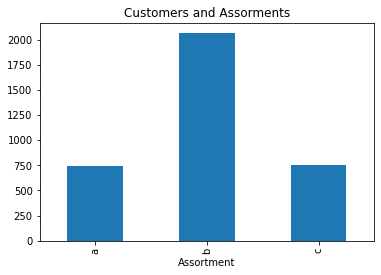

In [26]:
#Determining and visualize how Assortment affects the Customers
new = df.groupby(by=['Assortment'])['Customers'].mean()
new.head()
new.plot(kind='bar',title='Customers and Assorments')
plt.show()

In [27]:
#There are 4 store types and 3 merchandise
df.groupby(['StoreType','Assortment']).Assortment.count()

StoreType  Assortment
a          a             286028
           b                  0
           c             171014
b          a               6409
           b               8209
           c                942
c          a              58554
           b                  0
           c              54414
d          a              93884
           b                  0
           c             164884
Name: Assortment, dtype: int64

(array([1.28330e+05, 5.03908e+05, 1.67317e+05, 3.28390e+04, 8.82800e+03,
        2.34300e+03, 5.63000e+02, 1.74000e+02, 2.80000e+01, 8.00000e+00]),
 array([   46. ,  4196.5,  8347. , 12497.5, 16648. , 20798.5, 24949. ,
        29099.5, 33250. , 37400.5, 41551. ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, 'Histogram of Store Sales')

Text(0, 0.5, 'bins')

Text(0.5, 0, 'frequency')

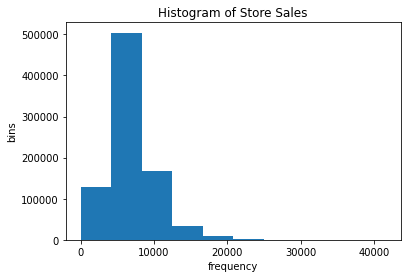

In [28]:
plt.hist(df['Sales'])
plt.title('Histogram of Store Sales')
plt.ylabel('bins')
plt.xlabel('frequency')
plt.show()

In [29]:
df.corr()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Day,Month,Year,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpenSince
Store,1.000000,0.000343,0.007723,0.033991,NaN,-0.000015,0.000526,-0.000127,0.001371,0.000300,-0.027080,0.007728,0.010853,0.007760,-0.008116
DayOfWeek,0.000343,1.000000,-0.178753,-0.097266,NaN,-0.289268,-0.139319,0.008525,-0.019710,0.002099,0.005540,-0.003252,-0.002736,-0.003249,-0.001317
Sales,0.007723,-0.178753,1.000000,0.823552,NaN,0.368199,0.038635,-0.051865,0.073589,0.036151,-0.035908,-0.127556,-0.058493,-0.127581,0.005220
Customers,0.033991,-0.097266,0.823552,1.000000,NaN,0.182859,0.024915,-0.035416,0.053843,-0.000842,-0.147859,-0.202207,-0.130864,-0.202180,0.001626
Open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Promo,-0.000015,-0.289268,0.368199,0.182859,NaN,1.000000,0.028971,-0.126442,-0.006412,0.023990,-0.002392,-0.000316,-0.000795,-0.000317,0.001001
SchoolHoliday,0.000526,-0.139319,0.038635,0.024915,NaN,0.028971,1.000000,0.038085,0.118467,-0.038686,-0.004256,-0.008244,-0.008069,-0.008247,0.000117
Day,-0.000127,0.008525,-0.051865,-0.035416,NaN,-0.126442,0.038085,1.000000,-0.006577,0.008387,-0.000227,0.001355,0.001450,0.001356,-0.000318
Month,0.001371,-0.019710,0.073589,0.053843,NaN,-0.006412,0.118467,-0.006577,1.000000,-0.268835,0.003882,-0.025807,-0.031721,-0.025812,-0.000737
Year,0.000300,0.002099,0.036151,-0.000842,NaN,0.023990,-0.038686,0.008387,-0.268835,1.000000,0.000632,-0.005696,-0.006905,-0.005697,0.000379


In [30]:
df.corr()["Sales"].sort_values()

DayOfWeek              -0.178753
Promo2SinceYear        -0.127581
Promo2                 -0.127556
Promo2SinceWeek        -0.058493
Day                    -0.051865
CompetitionDistance    -0.035908
CompetitionOpenSince    0.005220
Store                   0.007723
Year                    0.036151
SchoolHoliday           0.038635
Month                   0.073589
Promo                   0.368199
Customers               0.823552
Sales                   1.000000
Open                         NaN
Name: Sales, dtype: float64

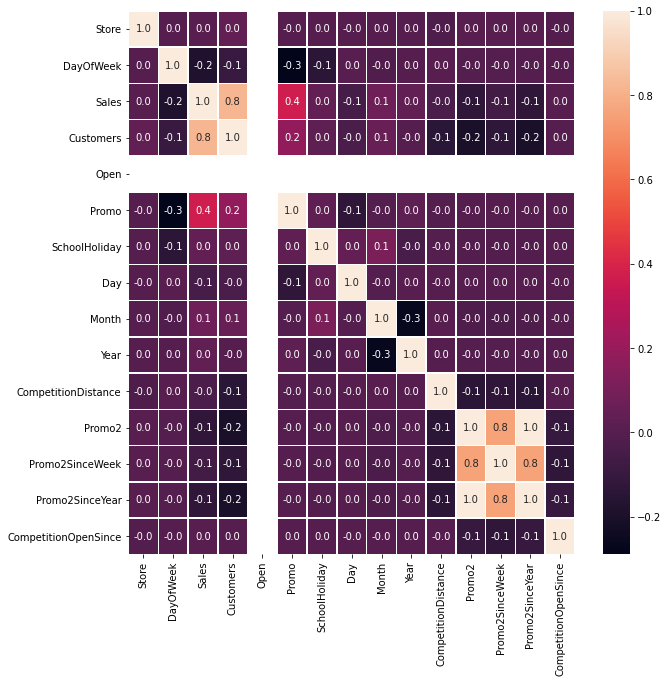

In [31]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

The feature StateHoliday changed into a boolean variable. The value {a, b, c} became 1, other 0;

In [32]:
df['is_holiday_state'] = df['StateHoliday'].map({'0': 0,
                                                 'a': 1,
                                                 'b': 1,
                                                 'c': 1
                                                }
)

del df['StateHoliday']

The features Assortment, StoreType, PromoInterval were coding with the get_dummies function;

In [33]:

df = pd.get_dummies(df, columns=['Assortment', 'StoreType', 'PromoInterval'],
                    prefix=['is_Assortment', 'is_StoreType', 'is_PromoInterval']
)

In [34]:
df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]

And finally, all these steps were done for test.csv.

In [35]:
df_test = pd.read_csv('test.csv',
                       sep=',',
                       parse_dates=['Date'],
                       date_parser=str_to_date,
                       low_memory=False
)

In [36]:
#df_test = df_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [37]:
df_test['Open'].fillna(1, inplace = True)

In [38]:
df_test['Day'] = df_test['Date'].dt.day
df_test['Month'] = df_test['Date'].dt.month
df_test['Year'] = df_test['Date'].dt.year

del df_test['Date']

In [39]:
df_test_store = pd.merge(df_test, df_store, how='left', on='Store')

In [40]:
df_test_store['StateHoliday'] = df_test_store['StateHoliday'].astype('category')
df_test_store['Assortment'] = df_test_store['Assortment'].astype('category')
df_test_store['StoreType'] = df_test_store['StoreType'].astype('category')
df_test_store['PromoInterval'] = df_test_store['PromoInterval'].astype('category')

In [41]:
df_test_store['CompetitionOpenSince'] = np.where((df_test_store['CompetitionOpenSinceMonth'] == 0) & (df_test_store['CompetitionOpenSinceYear'] == 0),
                                      0,
                                      (df_test_store['Month'] - df_test_store['CompetitionOpenSinceMonth']) + (12 * df_test_store['Year'] - df_test_store['CompetitionOpenSinceYear']))

del df_test_store['CompetitionOpenSinceYear']
del df_test_store['CompetitionOpenSinceMonth']

In [42]:
df_test_store['is_holiday_state'] = df_test_store['StateHoliday'].map({'0': 0,
                                                                       'a': 1,
                                                                       'b': 1,
                                                                       'c': 1
                                                                       }
)

del df_test_store['StateHoliday']

In [43]:
df_test_store = pd.get_dummies(df_test_store, columns=['Assortment', 'StoreType', 'PromoInterval'],
                               prefix=['is_Assortment', 'is_StoreType', 'is_PromoInterval']
)

In [44]:
df_test_store['is_holiday_state'] = df_test_store['is_holiday_state'].astype('int64')

In [45]:
df_test_store.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_test_store.columns]

Split on train and target;

In [46]:
features = df.drop(['Customers', 'Sales'], axis=1)
targets = np.log(df.Sales)

In [47]:
#### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features, targets,test_size=0.20,random_state=0)

In [48]:
def rmspe(true, pred):
    rmspe = np.sqrt(np.mean((true - pred)**2))
    return rmspe

### Linear Regression

In [49]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
y_pred = lin_reg.predict(X_test)

In [51]:
rmspe(y_test, y_pred)

0.3715884184615002

### Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor
rf_Regressor=RandomForestRegressor(n_estimators=10).fit(X_train,y_train)
prediction=rf_Regressor.predict(X_test)

In [53]:
y_pred = lin_reg.predict(X_test)

In [54]:
rmspe(y_test, y_pred)

0.3715884184615002

### XGBoost

In [55]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:linear')

xg_reg.fit(X_train, y_train)

[15:43:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [57]:
y_pred = xg_reg.predict(X_test)

In [58]:
rmspe(y_test,y_pred)

0.3281350734087717